# Lineær regression - Kan vi estimere antallet af linjer

- **Problem:** Kan jeg med ML estimere antallet af linjer en FED overskrift giver anledning til? Mine input data er FED data, hvor jeg har samlet en overskrift og det tilhørende *antal* linjer strategi hørende til overskriften. Dette er et lineært problem
- **Succes er** Jeg vil undersøge om en *lidt mere avaneret model* kan finde sammenhængen.Her forsøger jeg mig med EMBEDDING; CONV og recurrent GRU, bare for at vise, at jeg kan få det til at virke
- **Evaluering** Modellen evalueres ved at jeg deler data op i train, validering og test. train og validering opdeles atomatisk af Keras. Modellen valideres på *test*: Jeg plotter faktisk værdi ift predicted værdi. 
- **Data** hentes ud af FED i en tekst-fil. Den videre behandling sker i en Access-database og i et regneark. Input gemmes til sidst i et regneark
- **Baseline** Selv den bedste model har ikke rigtigt gjort det godt ind til nu, der er nok ikke system i data?
- **Optimering vs generalisering** Den får vi se på ...
- **Tuning hyper pametre** Den får vi se på ... 

Nedenfor er et par eksempler på hvordan data rigtigt ser ud. I eksemplet er en kort tekst med otte strategilinjer. Og den timsvarende omsættelse til inddata til modellen.

![title](FEDentry.GIF)

### Evaluering af forsøg

- Første kører, men den har svært ved at afvise de små
- Retter lidt i lagene, men det virker ikke bedre

### Konklusion

- Jeg Kan få EMBEDDING; CONV og recurrent GRU til at virke
- Model 10b er - alt andet lige - den som virker bedst

In [1]:
# henter data og lægger pænt i tabeller

# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')

# Excel-filen med tekster åbnes og indlæses
xl = pd.ExcelFile('FEDAll.xlsx')
df = xl.parse('FEDlinjer')       # siden i arket

# læs overskrifter i FED
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# læs antal linjer og omsæt til "stor hændelse" eller "lille hændelse"
NumLines = df.loc[:,'FEDlinjer']
NumLines = NumLines.values

# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
NumLines = NumLines[indices]

# opdeling i training data og test data
i = 80000  # antal linjer afsat til træning, resten er test
texts_train = texts[:i]
texts_test  = texts[i:] 
NumLines_train = NumLines[:i]
NumLines_test  = NumLines[i:]

In [2]:
# TOKENIZER - laver tekst om til vektor, henter text processing modul

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som nedenfor laves til en "one-hot")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Fandt %s unikke tokens.' % len(word_index))

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Fandt 21158 unikke tokens.


In [3]:
# Stop sætninger efter dette antal ord
maxlen = 50

# sætninger laves til tekst-vektor og der "paddes"
sequences = tokenizer.texts_to_sequences(texts_train)
data_train = pad_sequences(sequences, maxlen=maxlen)
sequences = tokenizer.texts_to_sequences(texts_test)
data_test = pad_sequences(sequences, maxlen=maxlen)

# labels laves til vektor
NumLines_train = np.asarray(NumLines_train).astype('float32')
NumLines_test = np.asarray(NumLines_test).astype('float32')

# print størrelsen på train og test data
print(data_train.shape)
print(data_test.shape)
print(NumLines_train.shape)
print(NumLines_test.shape)

(80000, 50)
(20867, 50)
(80000,)
(20867,)


In [4]:
from keras.models import Sequential
from keras.layers import Embedding
from keras import layers

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(layers.Conv1D(32, 9, activation='relu'))
#model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
#model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop',    # standard-optimizer
              loss='mse',             # mean square error
              metrics=['mae'])        # mean absolute error

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 8)             80000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 32)            2336      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 32)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 88,609
Trainable params: 88,609
Non-trainable params: 0
_________________________________________________________________


In [5]:
NumEpochs = 10
history = model.fit(data_train, NumLines_train,
                    epochs=NumEpochs,
                    batch_size=512,
                    validation_split=0.2)

Train on 64000 samples, validate on 16000 samples
Epoch 1/10
64000/64000 [==============================] - 8s 125us/step - loss: 22.0572 - mean_absolute_error: 2.1342 - val_loss: 24.7867 - val_mean_absolute_error: 2.1293
Epoch 2/10
64000/64000 [==============================] - 5s 76us/step - loss: 19.6683 - mean_absolute_error: 1.9735 - val_loss: 22.8408 - val_mean_absolute_error: 2.0279
Epoch 3/10
64000/64000 [==============================] - 5s 77us/step - loss: 18.2065 - mean_absolute_error: 1.8895 - val_loss: 21.9874 - val_mean_absolute_error: 1.9662
Epoch 4/10
64000/64000 [==============================] - 5s 77us/step - loss: 17.2643 - mean_absolute_error: 1.8391 - val_loss: 21.4629 - val_mean_absolute_error: 1.9940
Epoch 5/10
64000/64000 [==============================] - 5s 77us/step - loss: 16.5303 - mean_absolute_error: 1.8093 - val_loss: 21.2088 - val_mean_absolute_error: 1.9550
Epoch 6/10
64000/64000 [==============================] - 5s 78us/step - loss: 15.9602 - mean_

In [6]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [7]:
import matplotlib.pyplot as plt
plt.show()

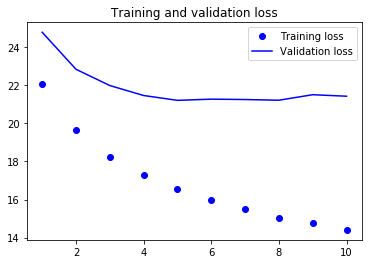

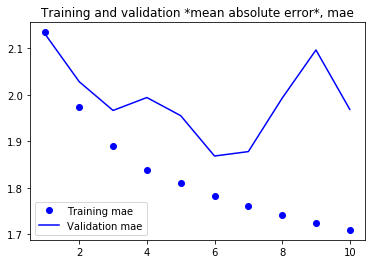

In [8]:
# plotter historikken for 'loss'
loss     = history.history['loss']
val_loss = history.history['val_loss']
mae      = history.history['mean_absolute_error']
val_mae  = history.history['val_mean_absolute_error']

epochs = range(1, NumEpochs+1)

plt.plot(epochs, loss, 'bo', label='Training loss')       # bo = "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b  = "solid blue line"
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation *mean absolute error*, mae')
plt.legend()
plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [9]:
# vi prøver modellen på test-data
predictions = model.predict(data_test)
for i in range(1,10):
    print(('%1.4f' % predictions[i]))

3.5732
2.2295
2.3033
3.1256
3.1196
2.6614
2.1654
1.9162
2.8888


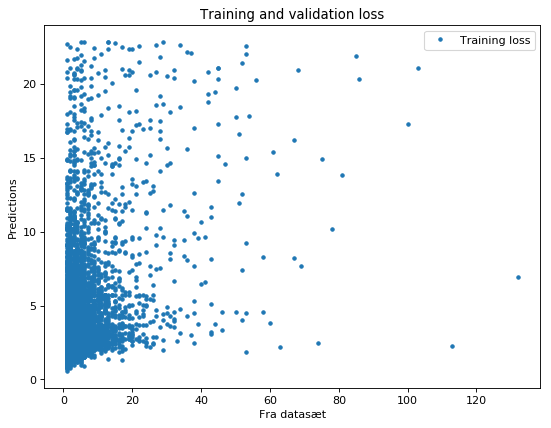

In [10]:
# plotter predictions vs 'hvad den faktisk skal være'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(NumLines_test, predictions, '.', label='Training loss')       # bo = "blue dot"
plt.xlabel('Fra datasæt')
plt.ylabel('Predictions')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
# prøver at forstå de linjer som er små, men som får en stor prediction
print('linje   SkalVære  Prediction  Tekst')
for i in range(1,len(predictions)):
    if NumLines_test[i]<3 and predictions[i]>10:
        PrtStr = (('%5.0f' % i) + '       ' + 
                  ('%4.0f' % NumLines_test[i]) + '        ' + 
                  ('%4.1f' % predictions[i]) + '  ' + 
                  texts_test[i][:70].replace('\n', ' ').replace('\r', ''))
        print(PrtStr)

linje   SkalVære  Prediction  Tekst
   87          2        10.5  Spærring på Kong Kristian d IX´s bro bevirker at 8303 aflyses Nf-Rf og
  395          1        20.4  Ingen trafik imellem NI og HG pga. nedfaldet træer og kørerledning
  514          2        19.8  Fjernstyringen gået ned mellem Hobro og Randers
  635          1        12.3  G 8733 er gået I stå mellem Trk-Ro. IC 149 er fanget bagved.
 1829          1        16.8  Signalfejl. Blokken er nede mellem Nykøbing F Vest og Rødby F. Tgl kan
 2122          1        12.9  Kh. 1xME. Nedbrudt. Varmt førerrum.
 2891          2        19.1  Nedbrudt i Nørre Alslev, løber omkring
 3320          1        13.6  Laskebrud i spor 3 på Høje Taastrup. Pt kører vi alle tog
 3349          2        11.6  Person i tunnel mellem Danmark og Sverige, trafikken stoppet
 3912          2        15.2  Disponering DSB. Eftermiddagens trafik i Næ.
 3933          1        13.7  K -12 g Pe.. Signalfejl efter sporspærring..
 4672          2        19.4  De

In [12]:
# prøver at forstå de linjer som modellen mener er store (predict > 20)
print('linje   SkalVære  Prediction  Tekst')
for i in range(1,len(predictions)):
    if predictions[i]>20:
        PrtStr = (('%5.0f' % i) + '       ' + 
                  ('%4.0f' % NumLines_test[i]) + '        ' + 
                  ('%4.0f' % predictions[i]) + '  ' + 
                  texts_test[i][:70].replace('\n', ' ').replace('\r', ''))
        print(PrtStr)

linje   SkalVære  Prediction  Tekst
   34         32          21  Øresundsbroen er lukket pga. storm. skrevet 03:32
  395          1          20  Ingen trafik imellem NI og HG pga. nedfaldet træer og kørerledning
 1149         52          21  Øvrige BDK Skinnebrud mellem Sø og Hb
 1302         45          21  Kørerstrøm : Manglende kørerstrøm mellem Ro og Rg 28/12. Disponeringer
 1527         27          23  Bane: Skinnebrud mellem Lg o Hd, Standartprocnose iværksat kl 04:00 fo
 2101         11          22  Vi får flere fejl  på infrastruktur mellem Lk og Es, så vi indstiller 
 2198          3          22  Der er skinnebrud ved Vk. Standardprognose 5 timer.
 2410         25          21  Overgravet Kabel Ky: Alle 41xx tog vendes i Bo indtil kl 15
 2593          9          22  Holder i Vi med fejl, lki på sagen  Strategi:  •	Trafikal vurd
 2812          6          23  •	Trafikal vurdering: Forsinkelser 5-10 min fra Kk-Kh •	Plan for ind
 3281         38          20  Sporskiftefejl i Helle